# Classification de discours suspect

## Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import time
import torch
import torch.nn as nn

/home/ibrahim/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import des données et EDA basique

In [2]:
data = pd.read_csv('./data/tweets_suspect.csv')
data.head()

,message,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1
1,is upset that he can't update his Facebook by ...,1
2,@Kenichan I dived many times for the ball. Man...,1
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",1


Label	Signification
* $0 \to$ Non suspect
* $1 \to$ Suspet (menaces, terrorismes, intimidation...)

In [3]:
print('Taille du dataset', len(data))
print('Shape du dataset', data.shape)

Taille du dataset 60000
Shape du dataset (60000, 2)


[]

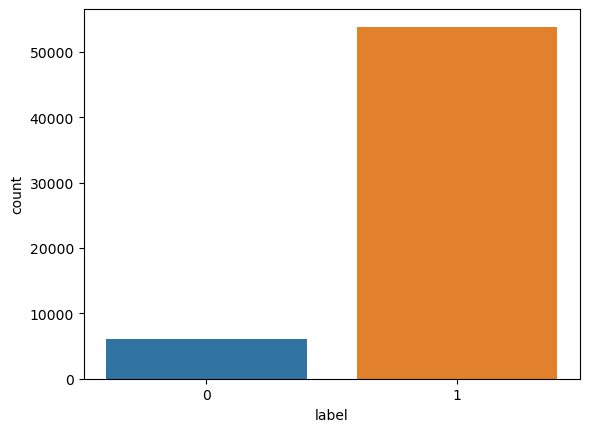

In [4]:
sns.countplot(x=data['label'])
plt.plot()

## Preprocessing des données

In [5]:
from string import punctuation
from nltk.tokenize import word_tokenize

def split_words_messages(data):
    text = list(data['message'].values)
    clean_text = []
    for t in text:
        clean_t = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', t)
        clean_t = clean_t.translate(str.maketrans('', '', punctuation)).lower().rstrip()
        clean_text.append(clean_t)
    tokenized = [word_tokenize(x) for x in clean_text]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)

    return tokenized, set(all_text)

messages, vocab = split_words_messages(data)
messages[0]

['switchfoot',
 'url',
 'awww',
 'thats',
 'a',
 'bummer',
 'you',
 'shoulda',
 'got',
 'david',
 'carr',
 'of',
 'third',
 'day',
 'to',
 'do',
 'it',
 'd']

In [6]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i, w in enumerate(words)}
    int_to_word_dict = {i:w for w, i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict

word_to_int_dict, int_to_word_dict = create_dictionaries(vocab)
int_to_word_dict

{1: 'quit',
 2: 'pedrogaspar',
 3: 'mountainmudbabe',
 4: 'twanking',
 5: 'seasonsad',
 6: 'benjaminellis',
 7: 'slipping',
 8: 'unintentionally',
 9: 'prays',
 10: 'guilds',
 11: 'ajax',
 12: 'espcially',
 13: 'ttyl',
 14: 'nellynoodler',
 15: 'participant',
 16: 'litrock',
 17: 'poisonivy69',
 18: 'loveno',
 19: 'lunchables',
 20: 'aris',
 21: 'avacado',
 22: 'davetran',
 23: 'fletcher',
 24: 'pyro',
 25: '365wholefoods',
 26: 'quotentrepreneurquot',
 27: 'tourdates',
 28: 'shure',
 29: 'bells',
 30: 'justsomeguy817',
 31: 'somemore',
 32: 'ptetty',
 33: 'lululemon',
 34: 'hardiks',
 35: 'fourmile',
 36: 'levimorales',
 37: 'jigglytuna',
 38: 'bjyork',
 39: 'jodiejudo',
 40: 'almonds',
 41: 'micalynmiller09',
 42: 'chewing',
 43: 'delivering',
 44: 'erikvb',
 45: 'daein',
 46: 'rejoin',
 47: 'miketempleton',
 48: 'dazed',
 49: 'velcro',
 50: 'framolamdu',
 51: 'hpylori',
 52: 'paypal',
 53: 'sydneyholidays',
 54: 'uff',
 55: 'monoprints',
 56: 'upsetting',
 57: 'malygos',
 58: 'boone

In [7]:
import numpy as np

print(np.max([len(x) for x in messages]))
print(np.mean([len(x) for x in messages]))

36
12.9985


In [8]:
def pad_text(tokenized_messages, seq_length):
    messages = []
    for message in tokenized_messages:
        if len(message) >= seq_length:
            messages.append(message[:seq_length])
        else:
            messages.append(['']*(seq_length-len(message)) + message)
    return np.array(messages, dtype=object)
padded_sentences = pad_text(messages, seq_length=36)
padded_sentences[0]

array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', 'switchfoot', 'url', 'awww', 'thats', 'a', 'bummer', 'you',
       'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to',
       'do', 'it', 'd'], dtype=object)

In [9]:
int_to_word_dict[0] = ''
word_to_int_dict[''] = 0

In [10]:
elements = np.array([mess for mess in padded_sentences])
elements

array([['', '', '', ..., 'do', 'it', 'd'],
       ['', '', '', ..., 'today', 'also', 'blah'],
       ['', '', '', ..., 'out', 'of', 'bounds'],
       ...,
       ['', '', '', ..., 'dreaming', 'of', 'you'],
       ['', '', '', ..., 'online', 'good', 'show'],
       ['', '', '', ..., 'no', 'worries', 'xx']], dtype=object)

In [11]:
encoded_sentences = np.array([[word_to_int_dict[word] for word in message] for message in padded_sentences])
encoded_sentences[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
       62742, 58648, 51259, 44423, 12967, 24166, 16056,  9429, 20568,
       40528, 13732, 47967, 21785, 54503, 46730, 62167,  3325,  4916])

## Model architeture

Notre modèle est composé de plusieurs parties

In [12]:
import torch
import torch.nn as nn

class ClassificationLSTM(nn.Module):
    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p=.8):
        super().__init__()
        self.n_vocab = n_vocab
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.embedding = nn.Embedding(n_vocab, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first=True, dropout=drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_words):
        embedded_words = self.embedding(input_words)
        lstm_out, h = self.lstm(embedded_words)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden)
        fc_out = self.fc(lstm_out)
        sigmoid_out = self.sigmoid(fc_out)
        sigmoid_out = sigmoid_out.view(batch_size, -1)
        sigmoid_last = sigmoid_out[:, -1]
        return sigmoid_last, h

    def init_hidden(self, batch_size):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),\
            weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return h

In [13]:
n_vocab = len(word_to_int_dict)
n_embed = 36
n_hidden = 100
n_output = 1
n_layers = 2
net = ClassificationLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers)

## Training the model

In [14]:
labels = np.array([int(x) for x in data['label'].values])

Définition des ratos d'entrainement et de validation:
* $80\%$ en données d'entrainement
* $10\%$ suivant en données de validation
* $10\%$ restant en données de test

In [15]:
train_ratio = 0.8
valid_ratio = (1 - train_ratio)/2

In [16]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 16

total = len(encoded_sentences)
train_cutoff = int(total * train_ratio)
valid_cutoff = int(total * (1 - valid_ratio))
train_x, train_y = torch.Tensor(encoded_sentences[:train_cutoff]).long(), torch.Tensor(labels[:train_cutoff]).long()
valid_x, valid_y = torch.Tensor(encoded_sentences[train_cutoff:valid_cutoff]).long(), torch.Tensor(labels[train_cutoff:valid_cutoff]).long()
test_x, test_y = torch.Tensor(encoded_sentences[valid_cutoff:]).long(), torch.Tensor(labels[valid_cutoff:]).long()
train_data = TensorDataset(train_x, train_y)
valid_data = TensorDataset(valid_x, valid_y)
test_data = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [17]:
net.cuda

<bound method Module.cuda of ClassificationLSTM(
  (embedding): Embedding(67811, 36)
  (lstm): LSTM(36, 100, num_layers=2, batch_first=True, dropout=0.8)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)>

In [18]:
import torch.optim as optim

print_every = 2400
step = 0
n_epochs = 10
clip = 5
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

# The main body of our training loop looks like this:
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size)

    for inputs, labels in train_loader:
        step+=1
        net.zero_grad()
        output, h = net(inputs)
        loss = criterion(output, labels.float()) # removed v_output.squeeze()
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        if (step % print_every) == 0:
            net.eval()
            valid_losses = []
            for v_inputs, v_labels in valid_loader:
                v_output, v_h = net(v_inputs)
                v_loss = criterion(v_output, v_labels.float()) # removed v_output.squeeze()
                valid_losses.append(v_loss.item())
            print("Epoch: {}/{}".format((epoch+1), n_epochs), "Step: {}".format(step), "Training Loss: {:.4f}".format(loss.item()), "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
            net.train()

Epoch: 1/10 Step: 2400 Training Loss: 0.0840 Validation Loss: 0.1909
Epoch: 2/10 Step: 4800 Training Loss: 0.6941 Validation Loss: 0.1532
Epoch: 3/10 Step: 7200 Training Loss: 0.0338 Validation Loss: 0.1398
Epoch: 4/10 Step: 9600 Training Loss: 0.0528 Validation Loss: 0.1405
Epoch: 4/10 Step: 12000 Training Loss: 0.0865 Validation Loss: 0.1290
Epoch: 5/10 Step: 14400 Training Loss: 0.0143 Validation Loss: 0.1538
Epoch: 6/10 Step: 16800 Training Loss: 0.0110 Validation Loss: 0.1549
Epoch: 7/10 Step: 19200 Training Loss: 0.0020 Validation Loss: 0.1924
Epoch: 8/10 Step: 21600 Training Loss: 0.0022 Validation Loss: 0.1973
Epoch: 8/10 Step: 24000 Training Loss: 0.0015 Validation Loss: 0.2262
Epoch: 9/10 Step: 26400 Training Loss: 0.0018 Validation Loss: 0.2736
Epoch: 10/10 Step: 28800 Training Loss: 0.0006 Validation Loss: 0.2548


In [20]:
torch.save(net.state_dict(), 'model.pkl')

In [22]:
net.eval()
test_losses = []
num_correct = 0
for inputs, labels in test_loader:
    test_output, test_h = net(inputs)
    loss = criterion(test_output, labels.float())
    test_losses.append(loss.item())

    preds = torch.round(test_output)
    correct_tensor = preds.eq(labels.float().view_as(preds))
    correct = np.squeeze(correct_tensor.numpy())
    num_correct += np.sum(correct)

print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f} %".format((num_correct/len(test_loader.dataset))*100))

Test Loss: 0.2169
Test Accuracy: 95.40 %
